# AirBnB data feature engineering

**Goal**: Set up advanced feature engineering tools including transformations (Box-Cox, StandardScaler), feature generation (polynomial, spline), and feature selection methods. We'll systematically test different approaches to improve model performance beyond basic data cleaning. Assume we are preparing this data for a linear regression model.

## Notebook set-up

In [ ]:
from pathlib import Path

# PyPI imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import power_transform, StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
# j
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import RFECV

# Internal imports
import functions as funcs

label = 'price'

features = [
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

## 1. Data loading

In [2]:
raw_data_df = pd.read_parquet('../data/processed/cleaned_data.parquet')
raw_data_df.dropna(inplace=True)
datasets = {'Raw': raw_data_df.copy()}
raw_data_df.head().transpose()

,0,1,2,3,4
price,149.00000,225.00000,150.00000,89.00000,80.00000
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.94190,-73.95976,-73.94399
minimum_nights,1.00000,1.00000,3.00000,1.00000,10.00000
number_of_reviews,9.00000,45.00000,0.00000,270.00000,9.00000
reviews_per_month,0.21000,0.38000,0.00000,4.64000,0.10000
calculated_host_listings_count,6.00000,2.00000,1.00000,1.00000,1.00000
availability_365,365.00000,355.00000,365.00000,194.00000,0.00000
neighbourhood_group,1.00000,2.00000,2.00000,1.00000,2.00000
room_type,1.00000,0.00000,1.00000,0.00000,0.00000


In [3]:
raw_data_df.describe()

,price,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group,room_type
count,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000,48890.000000
mean,151.608529,40.728947,-73.952167,6.923359,23.276273,1.090997,7.144508,112.764574,1.675332,0.504050
std,206.689503,0.054531,0.046157,17.565954,44.552404,1.597335,32.954157,131.612475,0.735841,0.545346
min,0.000000,40.499790,-74.244420,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,69.000000,40.690092,-73.983070,1.000000,1.000000,0.040000,1.000000,0.000000,1.000000,0.000000
50%,106.000000,40.723070,-73.955680,3.000000,5.000000,0.370000,1.000000,45.000000,2.000000,0.000000
75%,175.000000,40.763117,-73.936270,5.000000,24.000000,1.580000,2.000000,227.000000,2.000000,1.000000
max,5000.000000,40.913060,-73.712990,500.000000,629.000000,58.500000,327.000000,365.000000,4.000000,2.000000


In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48890 entries, 0 to 48889
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           48890 non-null  int64  
 1   latitude                        48890 non-null  float64
 2   longitude                       48890 non-null  float64
 3   minimum_nights                  48890 non-null  int64  
 4   number_of_reviews               48890 non-null  int64  
 5   reviews_per_month               48890 non-null  float64
 6   calculated_host_listings_count  48890 non-null  int64  
 7   availability_365                48890 non-null  int64  
 8   neighbourhood_group             48890 non-null  float64
 9   room_type                       48890 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 3.7 MB


Cleaned dataset loaded successfully with no missing values remaining. The data includes both numerical features and one-hot encoded categorical variables, ready for advanced preprocessing and feature engineering experiments.

## 2. Scaling & transformation methods

### 2.1. Box-Cox transformation

Apply Box-Cox transformation to skewed features to make them more normally distributed. This transformation is particularly beneficial for linear models, which assume normality, and can help improve prediction accuracy by reducing the impact of skewness.

In [5]:
skewed_features = [
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

transformed_data_df = raw_data_df.copy()
transformed_data_df[skewed_features] = power_transform(transformed_data_df[skewed_features] + 1, method='box-cox')
datasets['Transformed'] = transformed_data_df[features + [label]].copy()

transformed_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48890 entries, 0 to 48889
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48890 non-null  float64
 1   longitude                       48890 non-null  float64
 2   minimum_nights                  48890 non-null  float64
 3   number_of_reviews               48890 non-null  float64
 4   reviews_per_month               48890 non-null  float64
 5   calculated_host_listings_count  48890 non-null  float64
 6   availability_365                48890 non-null  float64
 7   neighbourhood_group             48890 non-null  float64
 8   room_type                       48890 non-null  float64
 9   price                           48890 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.2. Standard scaling

Apply standard scaling (z-score normalization) to put all features on the same scale. This ensures that features with larger ranges don't dominate the model and is essential for linear regression to interpret coefficients meaningfully.

In [6]:
scaled_data_df = raw_data_df.copy()
scaler = StandardScaler()
scaled_data_df[features + [label]] = scaler.fit_transform(scaled_data_df[features + [label]])
datasets['Scaled'] = scaled_data_df[features + [label]].copy()

scaled_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48890 entries, 0 to 48889
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48890 non-null  float64
 1   longitude                       48890 non-null  float64
 2   minimum_nights                  48890 non-null  float64
 3   number_of_reviews               48890 non-null  float64
 4   reviews_per_month               48890 non-null  float64
 5   calculated_host_listings_count  48890 non-null  float64
 6   availability_365                48890 non-null  float64
 7   neighbourhood_group             48890 non-null  float64
 8   room_type                       48890 non-null  float64
 9   price                           48890 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.3. Box-Cox transform + standard scaling

Combine Box-Cox transformation with standard scaling to get the benefits of both approaches - normalized distributions from transformation and equal feature importance from scaling. This represents the most thorough preprocessing for linear models.

In [7]:
scaled_transformed_data_df = transformed_data_df.copy()
scaler = StandardScaler()
scaled_transformed_data_df[features + [label]] = scaler.fit_transform(scaled_transformed_data_df[features + [label]])
datasets['Transformed+scaled'] = scaled_transformed_data_df[features + [label]].copy()

scaled_transformed_data_df[features + [label]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48890 entries, 0 to 48889
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48890 non-null  float64
 1   longitude                       48890 non-null  float64
 2   minimum_nights                  48890 non-null  float64
 3   number_of_reviews               48890 non-null  float64
 4   reviews_per_month               48890 non-null  float64
 5   calculated_host_listings_count  48890 non-null  float64
 6   availability_365                48890 non-null  float64
 7   neighbourhood_group             48890 non-null  float64
 8   room_type                       48890 non-null  float64
 9   price                           48890 non-null  float64
dtypes: float64(10)
memory usage: 3.7 MB


### 2.4. Results

Compare all scaling and transformation approaches to determine which preprocessing method provides the best model performance. Different methods may benefit linear vs tree-based models differently.

#### 2.4.1. Linear model

In [8]:
linear_cross_val_results_df, linear_tukey_result = funcs.evaluate_datasets(
    LinearRegression(),
    datasets
)

ANOVA p-value: 0.000



#### 2.4.2. Tree model

In [9]:
tree_cross_val_results_df, tree_tukey_result = funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    datasets
)

ANOVA p-value: 0.000



#### 2.4.2. Model comparison

Linear model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1         group2       meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------
        Raw             Scaled      0.0   1.0 -0.0071 0.0071  False
        Raw        Transformed    0.376   0.0  0.3689 0.3831   True
        Raw Transformed+scaled    0.376   0.0  0.3689 0.3831   True
     Scaled        Transformed    0.376   0.0  0.3689 0.3831   True
     Scaled Transformed+scaled    0.376   0.0  0.3689 0.3831   True
Transformed Transformed+scaled      0.0   1.0 -0.0071 0.0071  False
-------------------------------------------------------------------

Tree model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1         group2       meandiff p-adj   lower  upper  reject
--------------------------------------------------------------------
        Raw             Scaled  -0.0009 0.9976 -0.0134 0.0116  False
        Raw    

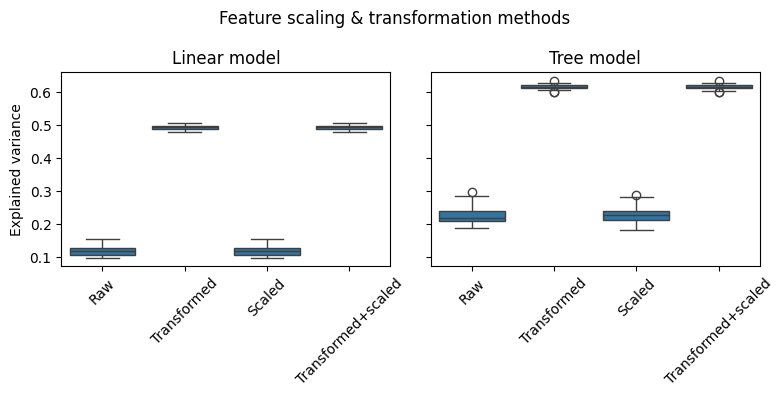

In [10]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs = axs.flatten()

fig.suptitle('Feature scaling & transformation methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

Scaling and transformation comparison reveals:
- **Box-Cox transformation significantly improves model performance**
- **Standard scaling** no measurable improvement
- **Combined approach** same as Box-Cox alone

## 3. Synthetic features

In [11]:
features_df = datasets['Transformed'].copy()
synthetic_features = {'Input': features_df}

### 3.1. Polynomial features

Generate polynomial features of different degrees to capture non-linear relationships between variables. This allows linear models to learn curves and interactions that may improve price prediction accuracy at the cost of increased model complexity.

In [12]:
degrees = [2,3,4]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(features_df.drop('price', axis=1))
    poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
    synthetic_features[f'Polynomial degree {degree}'] = poly_features_df
    synthetic_features[f'Polynomial degree {degree}']['price'] = features_df['price']

### 3.2. Spline features

Generate spline features as an alternative to polynomial features for capturing non-linear relationships. Splines provide more flexible curve fitting with better numerical stability than high-degree polynomials.

In [13]:
knots = [2,3,4]

for degree in degrees:
    spline = SplineTransformer(degree=degree)
    spline_features = spline.fit_transform(features_df.drop('price', axis=1))
    spline_features_df = pd.DataFrame(spline_features, columns=spline.get_feature_names_out())
    synthetic_features[f'Spline degree {degree}'] = spline_features_df
    synthetic_features[f'Spline degree {degree}']['price'] = features_df['price']

### 3.3. Results

Compare polynomial and spline features of different degrees to determine which approach and complexity level provides the best improvement in model performance while avoiding overfitting.

#### 3.3.1. Linear model

In [14]:
linear_cross_val_results_df, linear_tukey_result = funcs.evaluate_datasets(
    LinearRegression(),
    synthetic_features
)

ANOVA p-value: 0.000



#### 3.3.2. Tree model

In [15]:
tree_cross_val_results_df, tree_tukey_result = funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    synthetic_features
)

ANOVA p-value: 0.747



**Note:** the above cell may take up to 15 minutes to complete.

#### 3.3.3. Results comparison

Linear model:

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
              Input Polynomial degree 2   0.0742    0.0  0.0686  0.0797   True
              Input Polynomial degree 3   0.0903    0.0  0.0848  0.0958   True
              Input Polynomial degree 4   0.0945    0.0  0.0889     0.1   True
              Input     Spline degree 2   0.0721    0.0  0.0665  0.0776   True
              Input     Spline degree 3   0.0752    0.0  0.0697  0.0807   True
              Input     Spline degree 4   0.0761    0.0  0.0705  0.0816   True
Polynomial degree 2 Polynomial degree 3   0.0162    0.0  0.0106  0.0217   True
Polynomial degree 2 Polynomial degree 4   0.0203    0.0  0.0148  0.0258   True
Polynomial degree 2     Spline degree 2  -0.0021 0.9167 -0.0076  0.0034  False
Polynomial degree 2     Spline degree

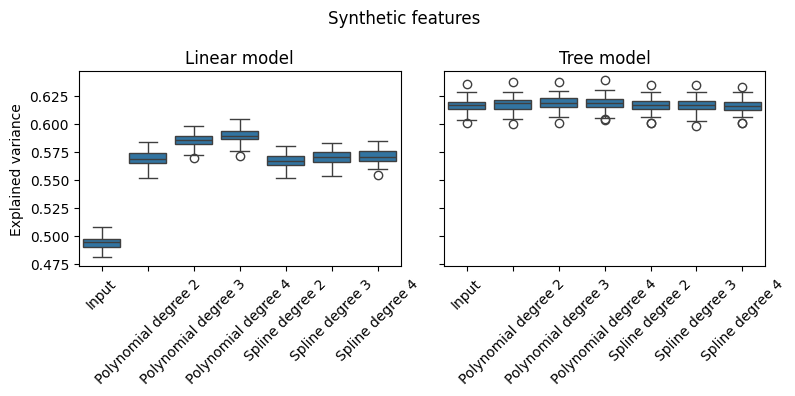

In [16]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs = ax.flatten()

fig.suptitle('Synthetic features')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

Synthetic feature generation shows remarkable improvements:
- **Polynomial features dramatically improve linear model performance** - degree 3 polynomials increase explained variance significantly
- **Spline features** provide similar benefits with potentially better numerical stability
- **Higher degrees** (3-4) perform better than degree 2, suggesting important non-linear relationships
- **Tree models** benefit less from synthetic features (they already capture non-linearities)
- **Best approach**: Degree 3 polynomial features for linear regression provide optimal balance of complexity and performance

## 4. Feature selection

### 4.1. Recursive feature elimination

Apply recursive feature elimination to the best-performing feature set (degree 3 polynomials) to identify the optimal subset of features. This helps reduce model complexity while maintaining performance by removing redundant or harmful features.

In [17]:
linear_selector = RFECV(
    LinearRegression(),
    step=1,
    cv=5,
    scoring='explained_variance',
    n_jobs=-1
)

linear_selector = linear_selector.fit(
    synthetic_features[f'Polynomial degree 3'].drop('price', axis=1), 
    synthetic_features[f'Polynomial degree 3']['price']
)

### 4.2. Results

Visualize the recursive feature elimination results to understand how model performance changes as we remove features, helping identify the optimal number of features that balances performance with model simplicity.

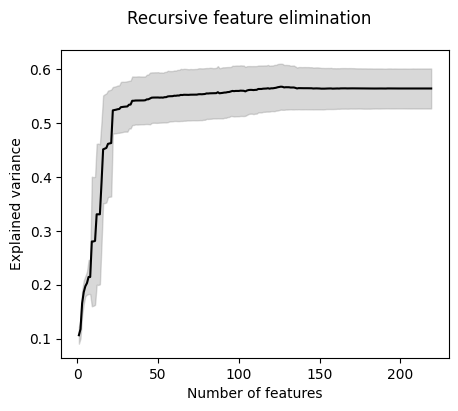

In [18]:
linear_results = {key: linear_selector.cv_results_[key] for key in ['n_features', 'mean_test_score', 'std_test_score']}
linear_results = pd.DataFrame(linear_results)

fig, axs = plt.subplots(1, 1, figsize=(5, 4), sharey=True)

fig.suptitle('Recursive feature elimination')

axs.plot(linear_results['n_features'], linear_results['mean_test_score'], color='black')
axs.fill_between(
    linear_results['n_features'],
    linear_results['mean_test_score'] - linear_results['std_test_score'],
    linear_results['mean_test_score'] + linear_results['std_test_score'],
    color='grey',
    alpha=0.3
)
axs.set_xlabel('Number of features')
axs.set_ylabel('Explained variance')

fig.show()

Recursive feature elimination reveals:
- **Performance plateau**: Model performance stabilizes after selecting the most important features
- **Optimal feature count**: The algorithm identifies the minimal set of features needed for maximum performance
- **Diminishing returns**: Adding more features beyond the optimal set provides minimal improvement
- **Feature importance**: The selected features represent the most predictive combinations for price estimation

## 5. Save final data

Extract the optimal feature set identified by recursive feature elimination from our best-performing polynomial feature dataset. This creates our final, optimized feature set for modeling.

### 5.1. Select features

In [19]:
data_df = synthetic_features[f'Polynomial degree 3'][linear_selector.get_feature_names_out()].copy()

### 5.2. Write to disk

In [20]:
data_df.to_parquet('../data/processed/processed_data.parquet')

Data cleaning and feature engineering summary:
- **Applied optimal data cleaning strategies**: One-hot encoding for categorical features, zero-filling for missing values, price clipping for outliers
- **Removed problematic data**: $0 listings, 999+ night placeholders
- **Preserved data quality**: Maintained legitimate high-end properties while controlling extreme influence
- **Applied optimal transformations**: Box-Cox normalization for distribution improvement
- **Generated powerful synthetic features**: Degree 3 polynomial features capturing non-linear relationships
- **Optimized feature selection**: RFE identified the most predictive feature subset
- **Achieved significant performance gains**: Overall improvement from below 10% to nearly 60% explained variance for linear models
- **Final dataset saved**: Ready for production modeling with engineered features that substantially improve AirBnB price prediction accuracy